The purpose of this notebook is to answer some questions about how to approach making an RL Agent for Halite.
An important note: great results have not been reached with this design, but this is mainly due to short training times, untuned hyperparameters, and a sparse reward system.
The design that we will be looking at contains three parts: an agent, an agent helper, and an environment. 
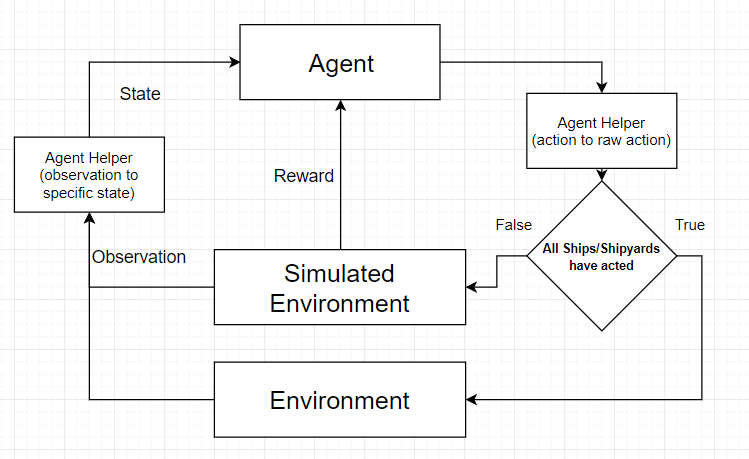
*Simulated Environment does not necessarily provide the reward

# Agent
One of the first problems encountered when designing a way to attack Halite is how to handle multiple ships (and shipyards) that can be created (also destroyed) with no concrete population limit. One solution is to make a limit, say 20 ships, and 5 shipyards, meaning we will have 25 agents that depending on the availability of ships and shipyards, will be used. However, this solution can be difficult to train and inefficient. The best solution is to create two agents one for ships and the other for shipyards, and for each ship and shipyard, we give a specific state (ex. a 5x5 matrix of halite values with the ship being in the center) to the ship and shipyard agents to predict actions for. This solution is much more efficient but can be somewhat difficult to implement for an RL Agent depending on the algorithm (DQN vs. A2C). The reason this is difficult is experience/memory for some algorithms (PG, A2C, etc.) must be temporally organized to calculate the discounted rewards, but we have multiple ships contributing to the same memory buffer. This difficulty is overcome by organizing experiences to be separately contained through a dictionary with UIDs for keys, and then upon a ship's destruction or the game-ending, they are orderly appended to the memory buffer.

The next problem we have just created with the above solution is that we need to make observations into specific states for each ship and shipyard. To handle this, we introduced agent helpers.

# Agent Helper
An agent helper does two things. First, it converts observations into specific states. Second, it converts actions into raw actions, which allows for the potential to check invalid actions before we do them. For ships we have an agent helper and for shipyards we have one also.

An example of the type of state a ship would need is a map of halite, a map of ships, and a map of shipyards all with the ship in the center. This becomes a large state with a size of 675 for a map of 15 units, so reducing the map to just a reasonable sized radius around the ship can be efficent, such as 5 making the state size 363.
An example of the type of state a shipyard would need is a list with the player halite, number of ships, current step, and if a ship is on the shipyard.

In [ ]:
from collections import deque

import numpy as np


MAP_SIZE = 21
CONVERT_COST = 500
SPAWN_COST = 500


class Helper:
    """This class is a template for agent helpers.
    """

    def __init__(self):
        self.state_shape = None
        self.action_shape = None
        self.memory = {}

    def convert_obs(self, uid, obs):
        return np.array([0])

    def convert_action(self, uid, obs, action):
        return 'NONE'

    def reset(self):
        pass

    def step(self):
        pass


class BasicShipyardHelper(Helper):
    """This class provides basic provisions for helping a shipyard agent.
    """

    def __init__(self):
        # steps, phalite, occupied, num ships
        self.state_shape = (4,)
        # None, spawn
        self.action_shape = (2,)

        self.reset()

    def convert_obs(self, uid, obs):
        phalite, shipyards, ships = obs.players[obs.player]
        occupied = shipyards[uid] in [x[0] for x in ships.values()]
        occupied = 1 if occupied else 0
        return np.array([obs.step, phalite, occupied, len(ships)])

    def convert_action(self, uid, obs, action):
        phalite, shipyards, ships = obs.players[obs.player]
        occupied = shipyards[uid] in [x[0] for x in ships.values()]
        if action == 1 and phalite >= SPAWN_COST and not occupied:
            return 'SPAWN'
        return 'NONE'


class BasicShipHelper(Helper):
    """This class provides basic provisions for helping a ship agent.
    """

    def __init__(self, stack=2, radius=5):
        self.stack = stack
        self.radius = radius
        self.frame_state_shape = (self.radius*2+1, self.radius*2+1, 2)
        self.state_shape = ((self.radius*2+1)**2 * 2 * self.stack,)
        self.action_shape = (6,)
        self.reset()

    def convert_obs(self, uid, obs):
        phalite, shipyards, ships = obs.players[obs.player]
        if uid not in self.state:
            self.state[uid] = deque(maxlen=self.stack)
            for _ in range(self.stack-1):
                self.state[uid].append(np.zeros(self.frame_state_shape))
        if uid in ships:
            entities_map = np.zeros((MAP_SIZE, MAP_SIZE))
            for player, (_, sy, s) in enumerate(obs.players):
                for shipyard in sy.values():
                    if obs.player == player:
                        entities_map[shipyard // MAP_SIZE,
                                     shipyard % MAP_SIZE] += 2
                    else:
                        entities_map[shipyard // MAP_SIZE,
                                     shipyard % MAP_SIZE] -= 2
                for ship in s.values():
                    if obs.player == player:
                        entities_map[ship[0] // MAP_SIZE,
                                     ship[0] % MAP_SIZE] += 1
                    else:
                        entities_map[ship[0] // MAP_SIZE,
                                     ship[0] % MAP_SIZE] -= 1
            halite_map = np.reshape(obs.halite, (MAP_SIZE, MAP_SIZE))
        
            state_map = np.stack([halite_map, entities_map], axis=2)
            state_map = np.tile(state_map, (3, 3, 1))

            spos, shalite = ships[uid]
            y = spos // MAP_SIZE + MAP_SIZE
            x = spos % MAP_SIZE + MAP_SIZE
            r = self.radius
            self.state[uid].append(state_map[y-r:y+r+1, x-r:x+r+1])
            return np.dstack(self.state[uid]).flatten()
        self.state[uid].append(np.zeros(self.frame_state_shape))        
        return np.dstack(self.state[uid]).flatten()

    def convert_action(self, uid, obs, action):
        phalite, shipyards, ships = obs.players[obs.player]
        pos, shalite = ships[uid]
        sy, sx = pos // MAP_SIZE, pos % MAP_SIZE

        if action == 0:
            return 'NONE'
        if action == 1:
            if phalite > CONVERT_COST and pos not in shipyards.values():
                return 'CONVERT'
            return 'NONE'
        if action == 2:
            return 'NORTH'
        if action == 3:
            return 'SOUTH'
        if action == 4:
            return 'WEST'
        if action == 5:
            return 'EAST'

    def reset(self):
        self.state = {}

# Environment
The goal of making an environment class is to wrap the halite kaggle environment in order to make it more friendly to RL agents. An RL agent needs to be able to get an environment state, manipulate an environment, get rewards, and check if the environment is complete. So, to fulfill what the agent needs, we make a step method that takes all the ship and shipyard actions and returns a new state, a reward, and a terminal. However, we have run into some problems. The first problem is that we need all the actions before we get a new state. The second problem is that the reward given by the halite kaggle environment is not the best and can be None in some circumstances. The third problem, specifically for ships, is that ships can be destroyed, which means the terminal for a ship differs from the terminal given by the halite kaggle environment.

**Solving the first problem**
In order to remove the need for all ships and shipyard actions to act before we get a result, we must implement a simulation of the halite kaggle environment. This simulation will take a ship or shipyard with an action and manipulate the observation as if only that action took place (the simulation does not need to be perfect; ex. not checking ship to ship collisions).

**Solving the second problem**
There are a couple ways to solve the problem of having a poor reward function. One could reward each ship based on its efficiency in gathering halite, but the solution we have focused on is the use of a sparse reward function where the agent in an episode is given a reward between -1 to 1 based on how much halite the player has compared to the best opponent. A reward for completing games early can also be given, where if the agent has won sooner than the max_step it gets a reward of 1, and if it has loss sooner a reward of -1.

**Solving the third problem**
This problem is solved by checking if a ship has been destroyed and if so adjusting the last terminal to True. It is important to avoid using the simulatated environment to check the destrustion as it is not guaranted, so if able use the actual halite kaggle environment observation to make the check.

In [ ]:
# Code below is incomplete
import os
from copy import deepcopy

from kaggle_environments import make


class HaliteEnv:
    def __init__(self, opponents, shipyard_helper, ship_helper,
                 replay_save_dir='', **kwargs):
        self.shipyard_helper = shipyard_helper
        self.ship_helper = ship_helper
        self.env = make('halite', **kwargs)
        self.trainer = self.env.train([None, *opponents])
        self.replay_save_dir = replay_save_dir

    def update_obs(self, uid, action):
        """Simulate environment step forward and update observation"""
        pass
    
    def reset(self):
        """Reset trainner environment"""
        self.obs = deepcopy(self.trainer.reset())
        return self.obs
    
    def step(self, actions):
        """Step forward in actual environment"""
        self.obs, reward, terminal, info = self.trainer.step(actions)
        self.obs = deepcopy(self.obs)
        return self.obs, reward, terminal
    
    def play_episdoe(self, shipyard_agent, ship_agent, max_steps=400):
        """Play one episode"""
        self.shipyard_helper.reset()
        self.ship_helper.reset()
        obs = self.reset()
        states = {}
        total_reward = 0
        for step in range(1, max_steps + 1):
            actions = {}
            phalite, shipyards, ships = obs.players[obs.player]
            init_shipyards = deepcopy(shipyards)
            init_ships = deepcopy(ships)
            
            for uid in init_shipyards.keys():
                # implementations vary
                # convert observation
                # select action
                # convert action
                # update simulated environment
                # Add experience/memory
                pass
            
            for uid in init_ships.keys():
                # implementations vary
                # convert observation
                # select action
                # convert action
                # update simulated environment
                # Add experience/memory
                pass
                
            obs, ep_reward, ep_terminal = self.step(actions)
            self.shipyard_helper.step()
            self.ship_helper.step()
            
            if ep_terminal:
                break

        # For sparse rewards we revise all ships and
        # shipyards last memory to be terminal and have the same reward
        # Important to note that training ships and shipyards at the same
        # time may produce poor results as they will get a reward that may
        # or may not represent that agents effectiveness.
        phalite, shipyards, ships = obs.players[obs.player]
        if obs.step < 399:
            if len(shipyards) == len(ships) == 0:
                total_reward = -1.0
            else:
                total_reward = 1.0
        else:
            halites = [halite for (halite, _, _) in obs.players]
            max_halite = np.max(halites)
            if max_halite == 0:
                max_halite = 1
            del halites[obs.player]
            total_reward = (phalite - np.max(halites)) / max_halite
        
        # Revise the last memory of each ship/shipyard
        # reward to be total_reward
        pass
    
        with open(os.path.join(self.replay_save_dir, 'out.html'), 'w') as file:
            file.write(self.env.render(mode='html'))
        
        

# Potential Improvements
**Reward System** The sparse reward system suggested in this design is not optimal. The same reward is given to each ship, and although the ships all have the same "brain," there is usually some stochasticity in the decision (for exploration). Thus, to some degree, the rewards are poorly correlated with an individual ship's performance. Therefore, one proposed solution is to add another reward on top of the winning/losing reward, which determines if the ship was proactive in helping to achieve the goal of winning. Proactiveness can be defined in different ways. The simplest is if the ship contributed to the player's halite, it is proactive. However, this will most likely lead to a greedy strategy, so taking into count the destruction of enemy entities may also be important in determining proactiveness. The idea of rewarding proactiveness can also be applied to shipyards, but of course, it needs to be defined differently than ship proactiveness.



# Conclusion
Hopefully, this notebook has answered the questions from [here](https://www.kaggle.com/c/halite/discussion/148923). The design and code were specifically made to work with [PAI-Utils](https://pypi.org/project/paiutils/), so implementation with other RL packages may be different.